# Car Price Prediction (Regression)

# Outline 

- Introduction
- Setup Environment
- Load Data
- Data Analysis (Quality Check)
- Data Analysis (General)
- Data Analysis (Hypothesis-Wise)
- Feature Selection
- Modeling
- Evaluation
    - MAE: Used for robustness against outlier errors
    - MSE: Used to penalize all range of error values
    - Residual Plot: Used to make sure no pattern appears in the error variance within the range

# Intorduction

***Quick Notes:*** No metadata was offered. **→** symbol means a developer's conversion is needed



Our goal in this project is to predict the selling_price, our dependant or response variable, using the best explantory or independant variable/s. For that, an assumption is made: One or more of the variables present can be a predictor of the price. One problem is that the data is scarce and thus, might not represents the actual distribution. Hence, train/test split will not be done before analysis (A rigorous technique to validate model's quality).


Target Value: 
- **selling_price** _(Continuous Float)_

Features:
- year _(Float → Ordinal but can be scaled immediately)_
- mileage _(Discrete Integer)_
- fuel_type _(String → ternary Nominal)_
- seller_type _(String → Binary Nominal)_
- transmission_type _(String → Binary Nominal)_
- previous_owners _(Discrete Integer)_

# Setup 

In [505]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams['font.size'] = 13.0
plt.rcParams.update({'legend.fontsize': 14, 'legend.handlelength': 2})

pd.options.mode.chained_assignment = None
# sns.set_style("whitegrid")

# Helper Functions

In [895]:
def pie_plot(df, feature):
    value_counts = df[feature].value_counts()
    labels = [label for label in value_counts.index]
    sizes = [size for size in value_counts]
    fig, ax = plt.subplots(figsize=(14,8))
    g = ax.pie(sizes, labels=labels, autopct='%1.1f%%', pctdistance = 1.15, labeldistance = 1.25)
    ax.axis('equal')
    plt.title(f"{feature} Groups Ratio in Dataset", fontsize=22);
    ax.title.set_position([.5, 1.05])
    
    
def evaluate(y_hat, y, res_plot=False):
    mae = mean_absolute_error(y_hat, y)
    mse = mean_squared_error(y_hat, y)
    print("MSE:", round(mse,4))
    print("MAE:", round(mae,4))
    if res_plot:
        fig, ax = plt.subplots(figsize=(14, 4))
        residuals = np.asarray(y - y_hat)
        residuals = StandardScaler().fit_transform(residuals.reshape(-1, 1))
        residuals = np.squeeze(residuals)
        y_hat_scaled = StandardScaler().fit_transform(y_hat.reshape(-1, 1).tolist())
        y_hat_scaled = np.squeeze(y_hat_scaled)
        sns.residplot(y_hat_scaled, residuals, color=(1, 0, 0, 0.3));
        plt.title("Residual Plot");
    return mse, mae

# Load

In [971]:
df = pd.read_csv("cars.csv")
print(f"#Samples = {df.shape[0]}\n#Features = {df.shape[1]}")
df.head()

#Samples = 301
#Features = 8


,car_name,year,mileage,fuel_type,seller_type,transmission_type,previous_owners,selling_price
0,ritz,2014.0,27000,Petrol,Dealer,Manual,0,3.35
1,sx4,2013.0,43000,Diesel,Dealer,Manual,0,4.75
2,ciaz,2017.0,6900,Petrol,Dealer,Manual,0,7.25
3,wagon r,2011.0,5200,Petrol,Dealer,Manual,0,2.85
4,swift,2014.0,42450,Diesel,Dealer,Manual,0,4.60


# Data Analysis (Quality Check)

In [972]:
df_nulls = df.isna().sum()
print(f"""Number of Null Values:
{df_nulls}

\t\t\t No time should be wasted on {round((df_nulls.sum()/df.shape[0])*100, 2)}% Null Ratio
""")
df = df.dropna()

Number of Null Values:
car_name             1
year                 2
mileage              0
fuel_type            0
seller_type          0
transmission_type    0
previous_owners      0
selling_price        1
dtype: int64

			 No time should be wasted on 1.33% Null Ratio



**Check string values misspellings**

In [973]:
print("fuel_type:", list(df['fuel_type'].unique()))
print("seller_type:", list(df['seller_type'].unique()))
print("transmission_type:", list(df['transmission_type'].unique()))

fuel_type: ['Petrol', 'Diesel', 'CNG']
seller_type: ['Dealer', 'Individual']
transmission_type: ['Manual', 'Automatic']


**Check negative values for numerical features**

_selling_price, mileage, year, previous_owners_ Must not be negative

In [974]:
zero_val_sum = (df[['selling_price', 'mileage', 'year', 'previous_owners']] < 0).sum().sum()
print(f"Number of Negative Values = {zero_val_sum}")

Number of Negative Values = 0


**Fix types**

We do not need numbers that exceed $±2^{32-1}-1 = INT_{32} Range$. Better for performance & memory (Of course we only have ~300 Examples so this specific step isn't very important)

In [975]:
df['year'] = df['year'].astype('int32')
df['mileage'] = df['mileage'].astype('int32')
df['previous_owners'] = df['previous_owners'].astype('int32')
df['selling_price'] = df['selling_price'].astype('float32')

In [976]:
df.dtypes

car_name              object
year                   int32
mileage                int32
fuel_type             object
seller_type           object
transmission_type     object
previous_owners        int32
selling_price        float32
dtype: object

# Data Analysis (General)

In [793]:
df.head()

,car_name,year,mileage,fuel_type,seller_type,transmission_type,previous_owners,selling_price
0,ritz,2014,27000,Petrol,Dealer,Manual,0,3.35
1,sx4,2013,43000,Diesel,Dealer,Manual,0,4.75
2,ciaz,2017,6900,Petrol,Dealer,Manual,0,7.25
3,wagon r,2011,5200,Petrol,Dealer,Manual,0,2.85
4,swift,2014,42450,Diesel,Dealer,Manual,0,4.60


In [451]:
df.describe().iloc[[1,2,3,7]].apply(round, args=(3,))

,year,mileage,previous_owners,selling_price
mean,2013.613,37011.943,0.040,4.614
std,2.890,39060.500,0.243,5.043
min,2003.000,500.000,0.000,0.100
max,2018.000,500000.000,3.000,35.000


**Note**:
features need scaling so that no one will control the model's weights for being too large compared to the other. Not doing so will cause a stretch through the axis that the largest feature rest on and overwhelm prediction

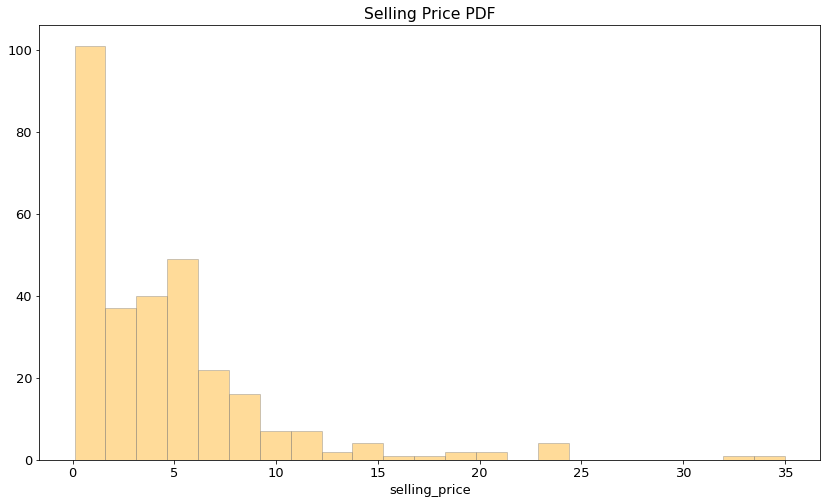

In [452]:
fig, ax = plt.subplots(figsize=(14,8))
sns.distplot(df['selling_price'], hist=True, kde=False, color = 'orange', hist_kws={'edgecolor':'gray'});
plt.title("Selling Price PDF");

**Note**

We have given the mean before an the central value for selling price. This is not a good measure of central value where having a right-skewed distribution

In [453]:
print("Central Value of Selling Price = ", round(df['selling_price'].median(),2))

Central Value of Selling Price =  3.6


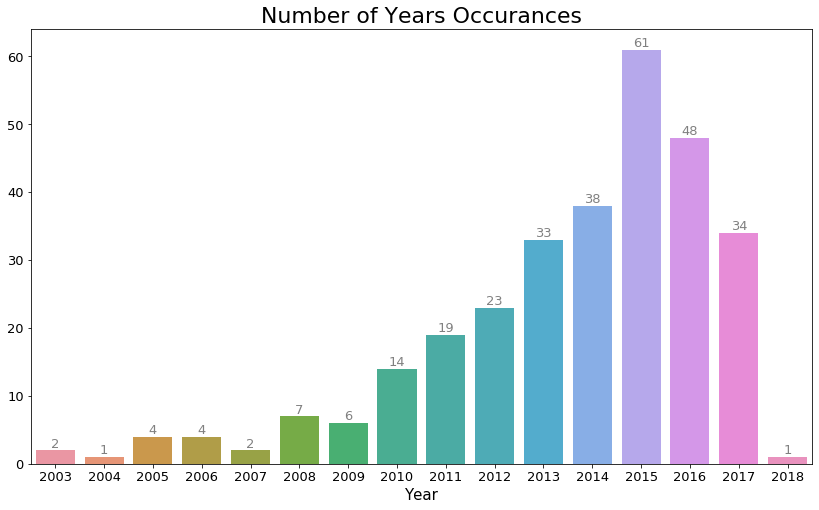

In [454]:
fig, ax = plt.subplots(figsize=(14,8))
g = sns.countplot(x="year", data=df)
plt.title("Number of Years Occurances", fontsize=22)
plt.ylabel("", fontsize=15)
plt.xlabel("Year", fontsize=15)

for p in g.patches:
    g.annotate(p.get_height(), (p.get_x()+0.4, p.get_height()), ha='center', va='bottom', color= 'gray')

Number of cars =  98


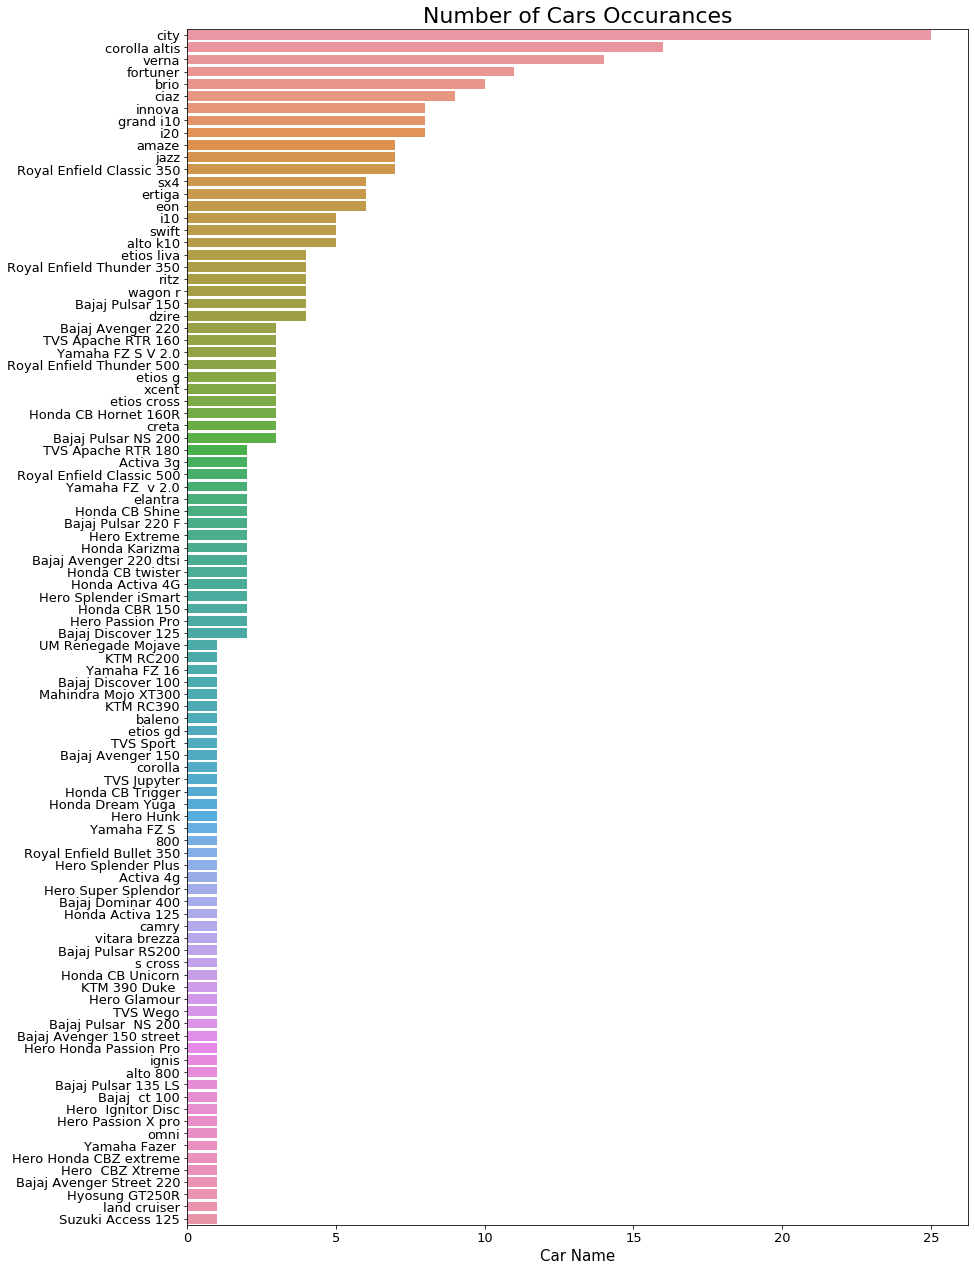

In [455]:
print("Number of cars = ", len(df['car_name'].unique()))
fig, ax = plt.subplots(figsize=(14,22))
g = sns.countplot(y="car_name", data=df, orientation='horizontal', order = df['car_name'].value_counts().index)
plt.title("Number of Cars Occurances", fontsize=22)
plt.ylabel("", fontsize=15)
plt.xlabel("Car Name", fontsize=15);

**Note**:

There is a high possiblity that the model will overfit the car's name if we added this feature. This type of features with respect to the number of samples we have, as well as the distribution of samples per car name is bad for the model for two reasons.
1. Nominality of the feature where it represents no ordinality taking into account 98 categories.
2. For many samples, it almost is similar to an ID in the case of our dataset.

But, removal might be bad as they represent the car's selling range if we were to have many samples for each. Also, extracting the company names for each will give the model more power in generalizability (Will not be done due to time). 

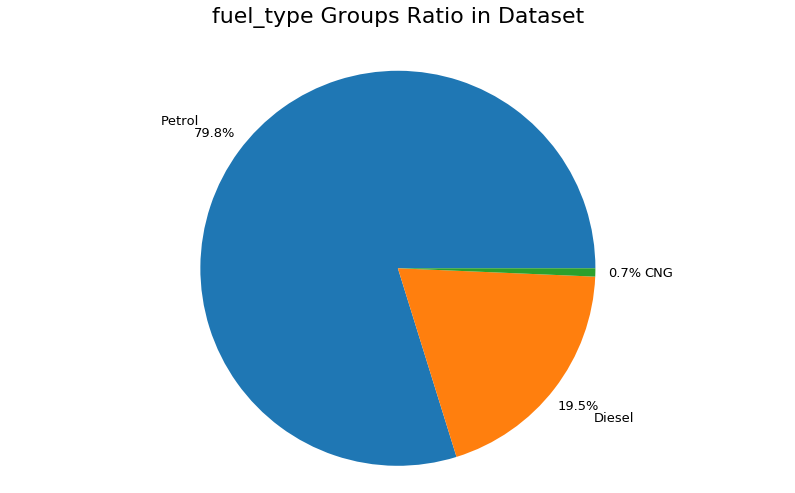

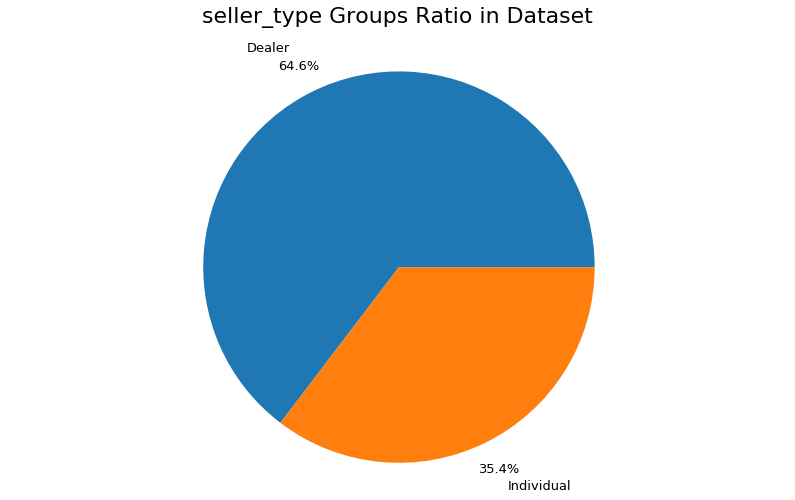

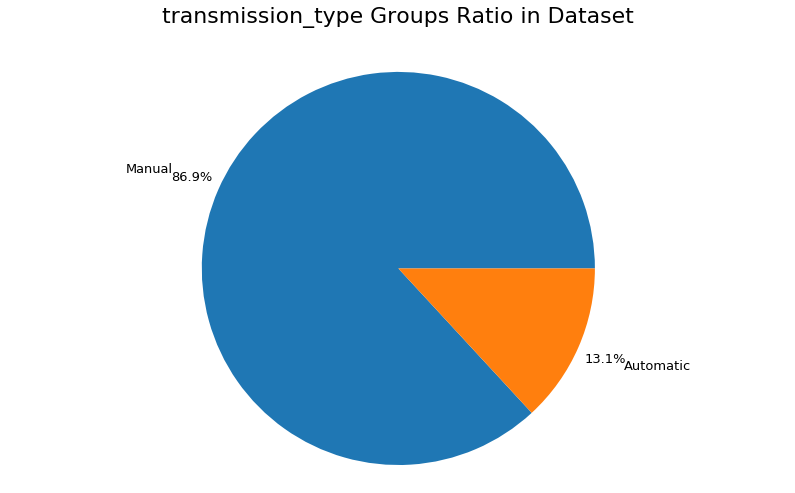

In [456]:
pie_plot(df, 'fuel_type')
pie_plot(df, 'seller_type')
pie_plot(df, 'transmission_type')

**Note**

Our only concern here is **CNG** Category as it doesn't have any representation in the dataset. However, it's not a problem but a note is given to help in modeling

# Data Analysis, Feature Selection (Hypothesis-Wise)

In [457]:
# df.groupby(['fuel_type', 'transmission_type'])['selling_price'].median().plot(kind='bar')

**Note:**

Seaborn package uses the _mean()_ function to estimate the central tendency of a variable distribution. The selling price has a couple of outliers and is, as discussed before, right-skewed. We have changed the estimator to be the median below. You can also use the function commented above to break down the code below and how it works

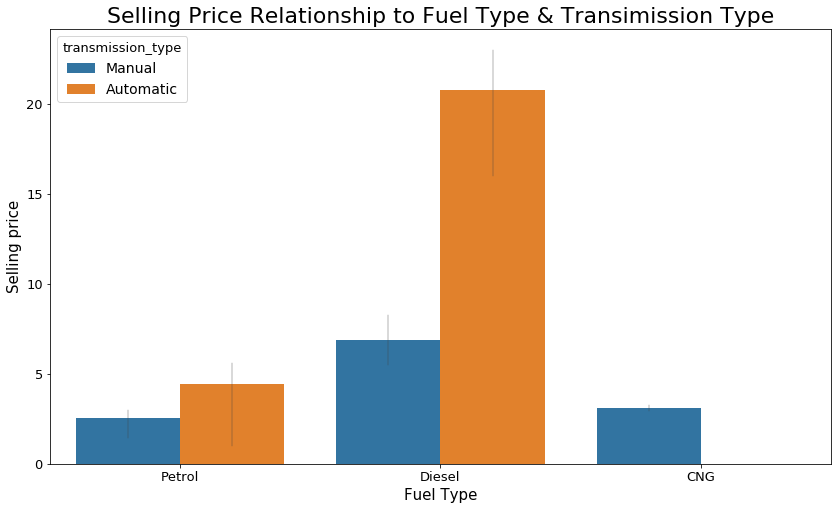

In [458]:
fig, ax = plt.subplots(figsize=(14,8))
sns.barplot(data=df, y='selling_price', x='fuel_type', hue='transmission_type', errwidth=0.4, estimator=np.median);
plt.title("Selling Price Relationship to Fuel Type & Transimission Type", fontsize=22)
plt.ylabel("Selling price", fontsize=15)
plt.xlabel("Fuel Type", fontsize=15);

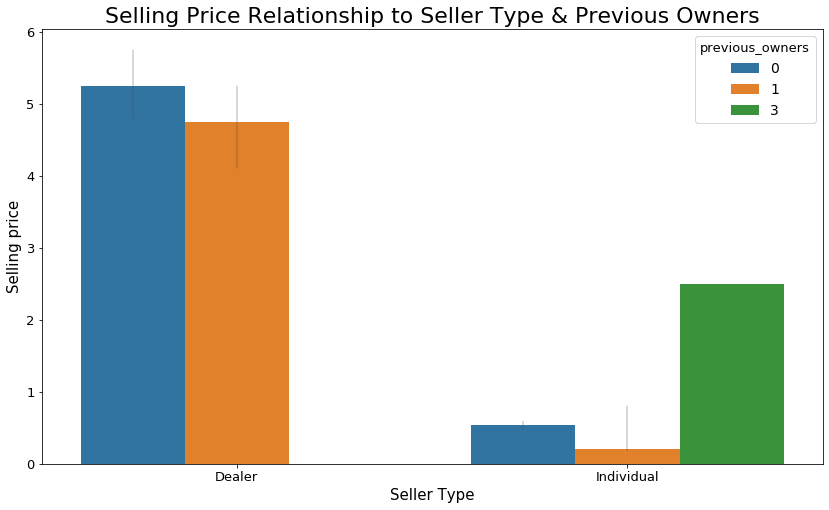

In [979]:
fig, ax = plt.subplots(figsize=(14,8))
sns.barplot(data=df, y='selling_price', x='seller_type', hue='previous_owners', errwidth=0.4, estimator=np.median);
plt.title("Selling Price Relationship to Seller Type & Previous Owners", fontsize=22)
plt.ylabel("Selling price", fontsize=15)
plt.xlabel("Seller Type", fontsize=15);

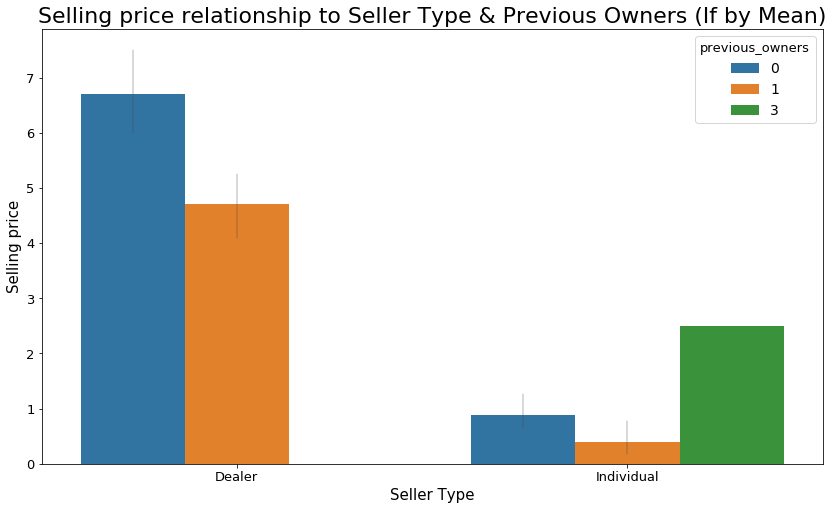

In [460]:
fig, ax = plt.subplots(figsize=(14,8))
sns.barplot(data=df, y='selling_price', x='seller_type', hue='previous_owners', errwidth=0.4, estimator=np.mean);
plt.title("Selling price relationship to Seller Type & Previous Owners (If by Mean)", fontsize=22)
plt.ylabel("Selling price", fontsize=15)
plt.xlabel("Seller Type", fontsize=15);

**Note**

Notice that we have higher numbers. This must happen as when we have a right-skewed distribution, mean value is pushed by large numbers to the right. Median is more stable against outliers

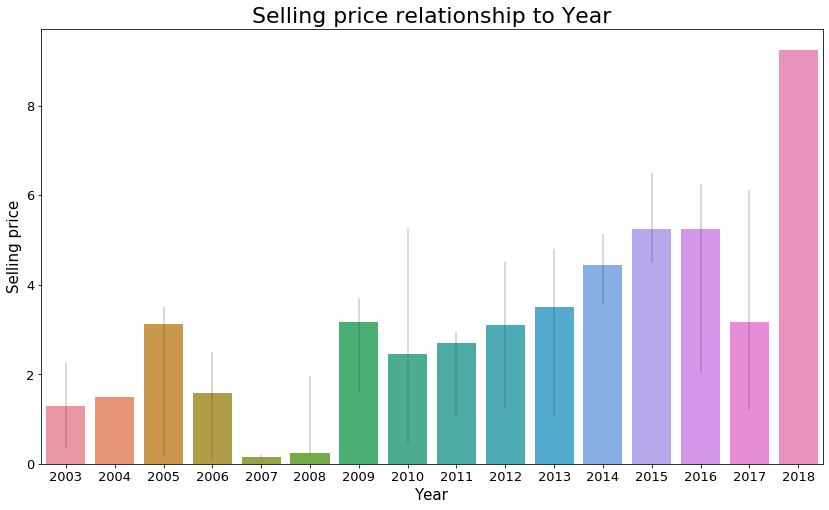

In [550]:
fig, ax = plt.subplots(figsize=(14,8))
sns.barplot(data=df, y='selling_price', x='year', errwidth=0.4, estimator=np.median);
plt.title("Selling price relationship to Year", fontsize=22)
plt.ylabel("Selling price", fontsize=15)
plt.xlabel("Year", fontsize=15);

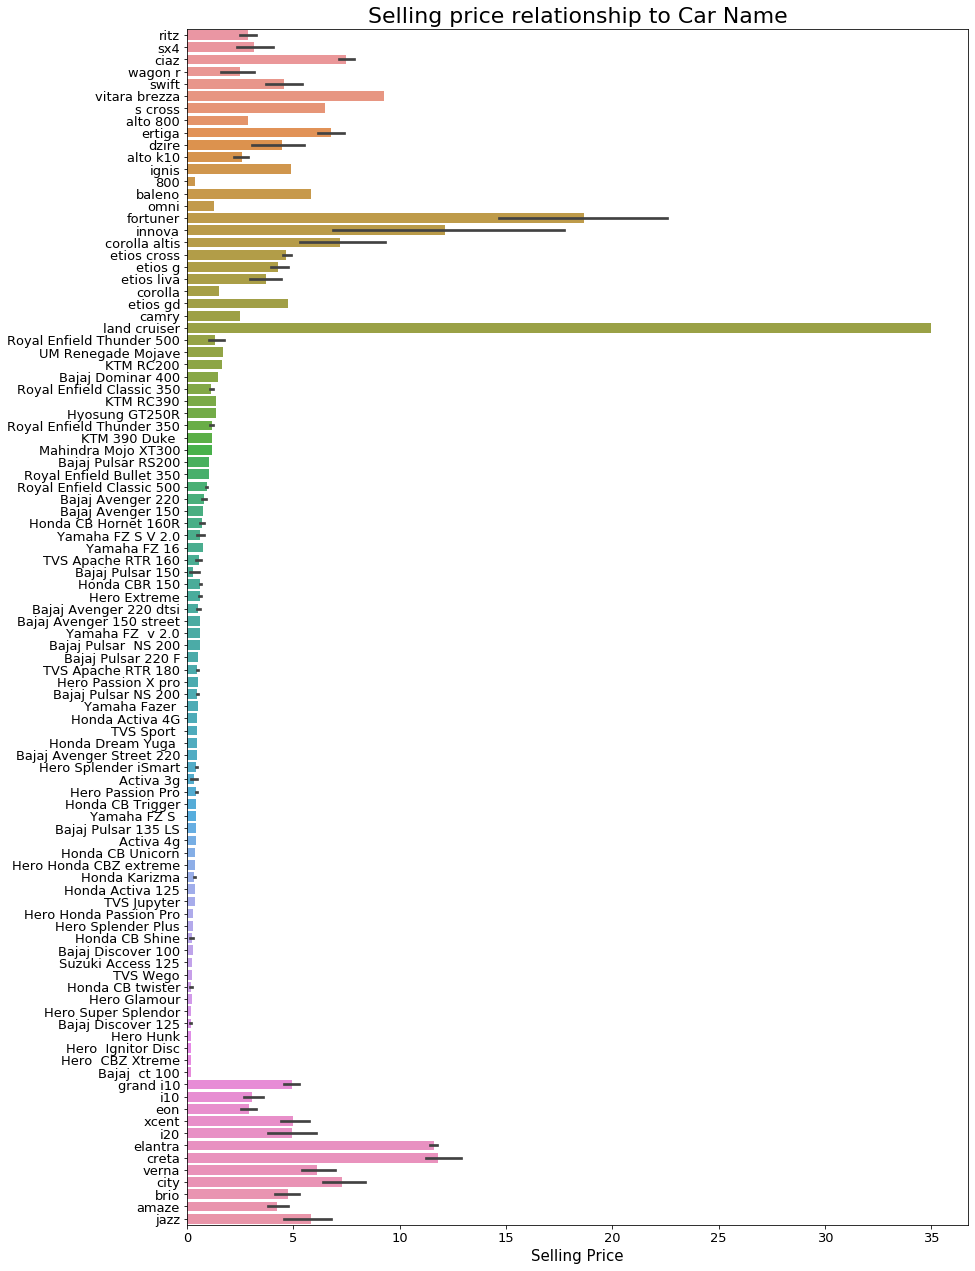

In [977]:
fig, ax = plt.subplots(figsize=(14,22))
g = sns.barplot(x ='selling_price', y="car_name", data=df, orientation='horizontal')
plt.title("Selling price relationship to Car Name", fontsize=22)
plt.ylabel("", fontsize=15)
plt.xlabel("Selling Price", fontsize=15);

**INSIGHTS**

- When the seller is **dealer**, we have a higher price. positive correlation is possible
- When we have an **Automatic** car that runs on **Diesel**, price goes up. Positive correlation with two variables, **regression trees** might be great here, as well as **Intraction Regression**.
- Car Name might be helpful if we can **select a few**
- Other instights exist too

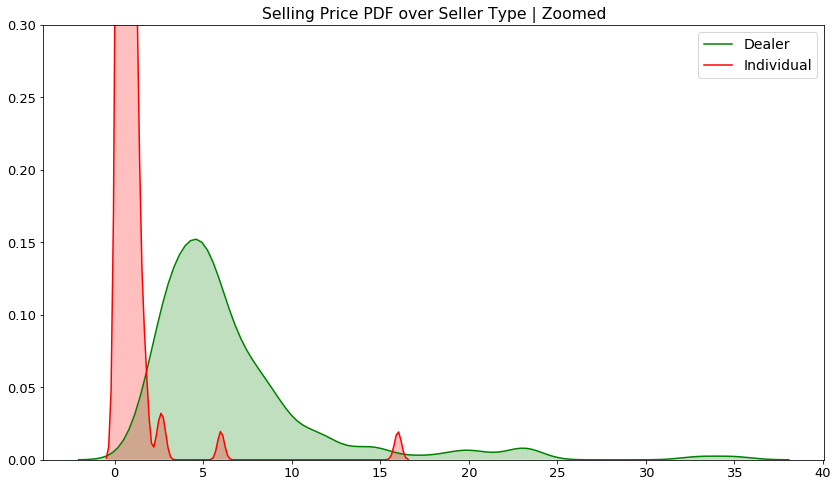

In [754]:
fig, ax = plt.subplots(figsize=(14,8))

sns.kdeplot(df[df['seller_type'] == 'Dealer']['selling_price'], color='g', shade=True, Label='Dealer') 
sns.kdeplot(df[df['seller_type'] == 'Individual']['selling_price'], color='r', shade=True, Label='Individual')
plt.ylim(0,0.3);
plt.title("Selling Price PDF over Seller Type | Zoomed");

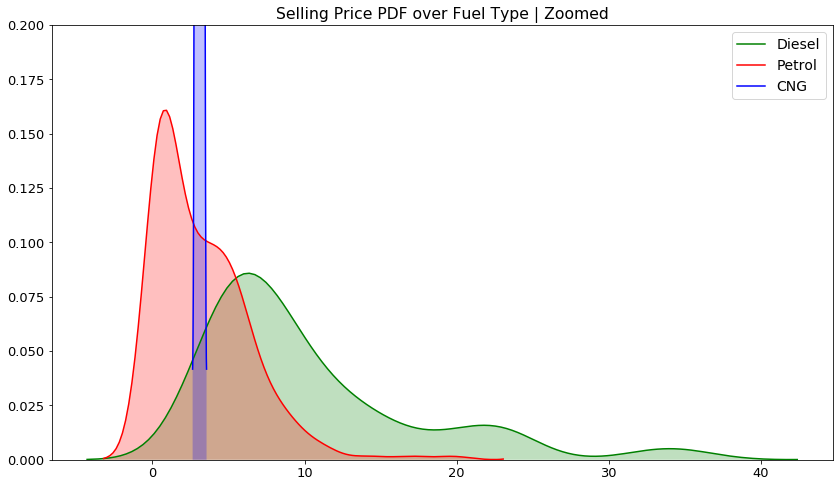

In [756]:
fig, ax = plt.subplots(figsize=(14,8))

sns.kdeplot(df[df['fuel_type'] == 'Diesel']['selling_price'], color='g', shade=True, Label='Diesel') 
sns.kdeplot(df[df['fuel_type'] == 'Petrol']['selling_price'], color='r', shade=True, Label='Petrol')
sns.kdeplot(df[df['fuel_type'] == 'CNG']['selling_price'], color='b', shade=True, Label='CNG')
plt.ylim(0,0.2);
plt.title("Selling Price PDF over Fuel Type | Zoomed");

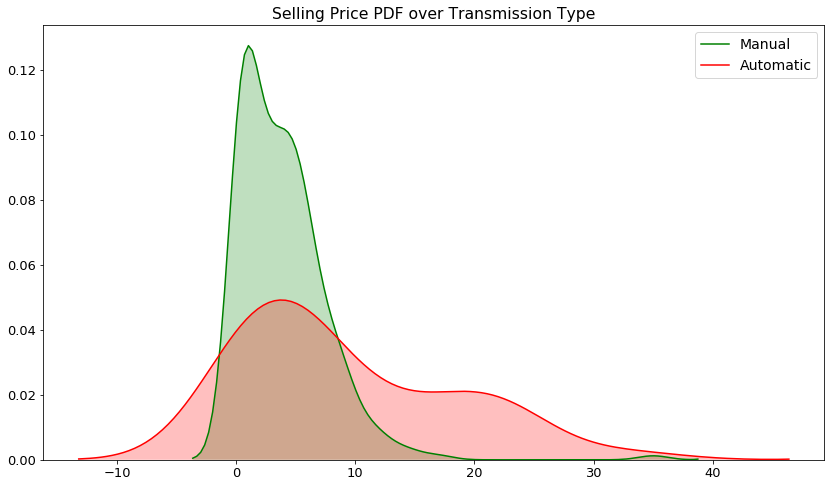

In [760]:
fig, ax = plt.subplots(figsize=(14,8))

sns.kdeplot(df[df['transmission_type'] == 'Manual']['selling_price'], color='g', shade=True, Label='Manual') 
sns.kdeplot(df[df['transmission_type'] == 'Automatic']['selling_price'], color='r', shade=True, Label='Automatic')
plt.title("Selling Price PDF over Transmission Type");

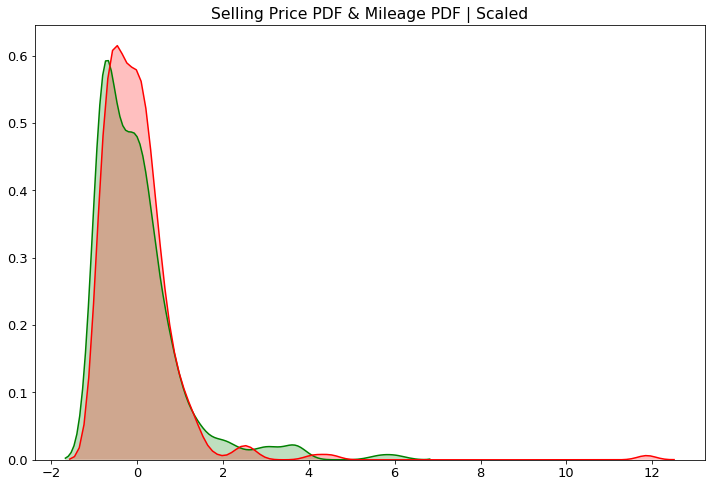

In [778]:
kde_scaled = StandardScaler().fit_transform(df[['selling_price', 'mileage']])
sns.kdeplot(kde_scaled.take(0, axis=1), color='g', shade=True, Label='Selling Price') 
sns.kdeplot(kde_scaled.take(1, axis=1), color='r', shade=True, Label='Mileage');
plt.title("Selling Price PDF & Mileage PDF | Scaled");

**Note:**

The last plot gives a relationship. previous plots give us an intuition on where the values of the selling price are at with respect to a category

# Feature Selection

## Encoding Qualitative Variables (Further Analysis)

**One-Hot Encoding Nominals**

This distinction is very important, large values for Nominals are not meaningful and will mislead the model

In [794]:
df = df.sort_values(by='year')

In [795]:
transmission_type = pd.get_dummies(df['transmission_type'])
fuel_type = pd.get_dummies(df['fuel_type'])
seller_type = pd.get_dummies(df['seller_type'])
car_name = pd.get_dummies(df['car_name'])
df = df.drop(['car_name', 'fuel_type', 'seller_type', 'transmission_type'], axis=1)
merged_df = seller_type.merge(transmission_type, left_index=True, right_index=True)
merged_df = merged_df.merge(fuel_type, left_index=True, right_index=True)

**Encoding Ordinals**

In [796]:
from sklearn.preprocessing import LabelEncoder 
lb = LabelEncoder()
df['year'].sort_values()
year = lb.fit_transform(df['year'])
df['year_encoded'] = year
df[['year', 'year_encoded']].drop_duplicates().values

array([[2003,    0],
       [2004,    1],
       [2005,    2],
       [2006,    3],
       [2007,    4],
       [2008,    5],
       [2009,    6],
       [2010,    7],
       [2011,    8],
       [2012,    9],
       [2013,   10],
       [2014,   11],
       [2015,   12],
       [2016,   13],
       [2017,   14],
       [2018,   15]], dtype=int64)

In [797]:
df = merged_df.merge(df, left_index=True, right_index=True).sort_index().drop('year', axis=1)

In [798]:
df.head()

,Dealer,Individual,Automatic,Manual,CNG,Diesel,Petrol,mileage,previous_owners,selling_price,year_encoded
0,1,0,0,1,0,0,1,27000,0,3.35,11
1,1,0,0,1,0,1,0,43000,0,4.75,10
2,1,0,0,1,0,0,1,6900,0,7.25,14
3,1,0,0,1,0,0,1,5200,0,2.85,8
4,1,0,0,1,0,1,0,42450,0,4.60,11


- We will exclude car names __for now__ as it's very noisy for further analysis. 
- We have to train/test split now by 15%, which is almost the largest we can get to due to data scarcity

**SPLIT**

In [799]:
from sklearn.model_selection import train_test_split
X = df.drop(['selling_price'], axis=1)
y = df['selling_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True)

**SCALE**

- Scaling was done mainly due to mileage & year encoded featuers
- Not needed for tree-based models but distance-based models might be used. 

In [800]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler().fit(X_train)
X_train_sc = scaler.transform(X_train)
X_train_sc = pd.DataFrame(X_train_sc, index=X_train.index, columns=X_train.columns)
X_train_sc.head()

,Dealer,Individual,Automatic,Manual,CNG,Diesel,Petrol,mileage,previous_owners,year_encoded
237,0.675757,-0.675757,-0.367607,0.367607,-0.089443,1.914854,-1.870829,0.734710,-0.170486,0.489167
32,0.675757,-0.675757,-0.367607,0.367607,-0.089443,1.914854,-1.870829,0.023320,-0.170486,0.118987
95,0.675757,-0.675757,-0.367607,0.367607,-0.089443,-0.522233,0.534522,0.832832,-0.170486,-0.621375
115,-1.479822,1.479822,-0.367607,0.367607,-0.089443,-0.522233,0.534522,-0.504090,-0.170486,0.489167
31,0.675757,-0.675757,-0.367607,0.367607,-0.089443,-0.522233,0.534522,0.396186,-0.170486,-0.991555


## Correlation Matrix

**Note:**

Some redundancies in the matrix can be spotted but just ignore. We have to one-hot encode nominals for further steps

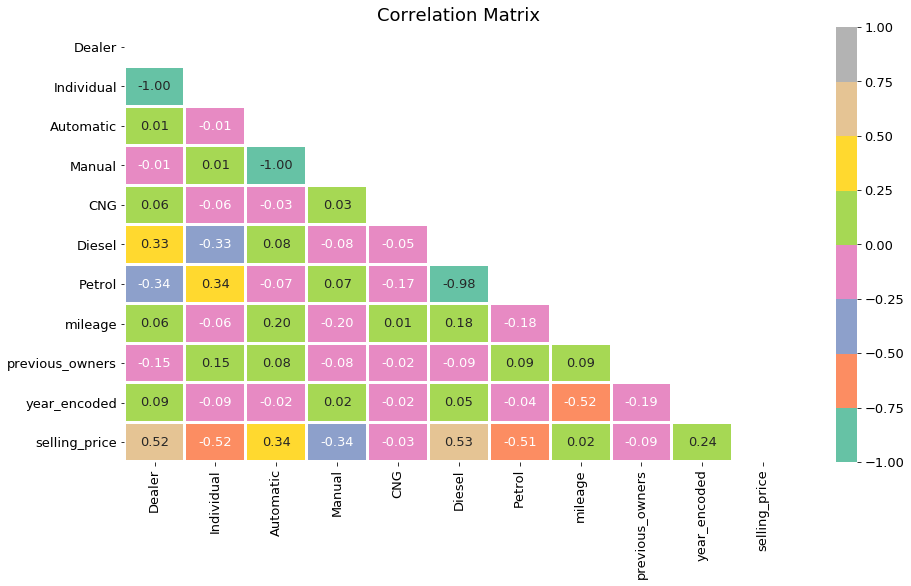

In [801]:
fig, ax = plt.subplots(figsize=(15,8))

ax.axes.set_title("Correlation Matrix",fontsize=18)
ax.tick_params(labelsize=13)

corr = X_train_sc.merge(y_train, left_index=True, right_index=True).corr()
mask = np.triu(corr)
sns.heatmap(corr, cmap= 'Set2', linewidths=2, ax=ax, annot=True, mask=mask, fmt='.2f');

**INSIGHTS:**

positive correlation between our response variable and (I won't mention redundancies):
- Dealer
- Automatic
- Diesel
- year_encoded (Slightly)

In [890]:
lgbm = LGBMRegressor(n_jobs=-1).fit(X_train_sc, y_train)
preds = lgbm.predict(X_train_sc)
evaluate(preds, y_train);

MSE: 6.2534
MAE: 1.3716


In [891]:
rf_reg = RandomForestRegressor(n_jobs=-1).fit(X_train_sc, y_train)
preds = rf_reg.predict(X_train_sc)
evaluate(preds, y_train);

MSE: 1.5767
MAE: 0.6607


In [892]:
from sklearn import linear_model
lasso = linear_model.Lasso(alpha=0.01)
lasso.fit(X_train_sc, y_train)
preds = lasso.predict(X_train_sc)
evaluate(preds, y_train);

MSE: 11.6441
MAE: 2.0827


**Note:**

Apparently, bagging works better than boosting

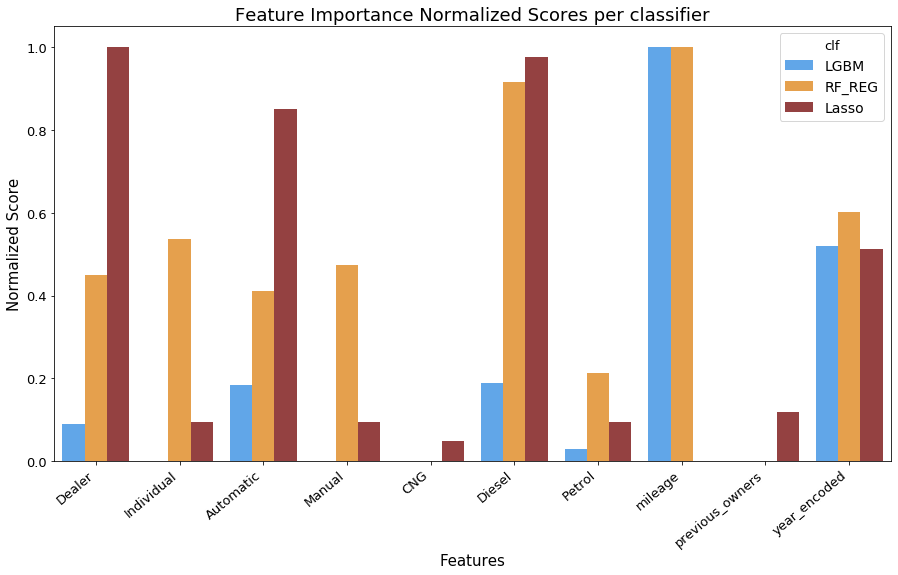

In [805]:
coef_lgbm = pd.DataFrame(lgbm.feature_importances_, columns=['Importance'])
coef_lgbm['Feature'] = X_train_sc.columns
coef_lgbm["clf"] = 'LGBM'
coef_lgbm['Importance'] = MinMaxScaler().fit_transform(coef_lgbm['Importance'].values.reshape(-1, 1))


coef_rf_reg = pd.DataFrame(rf_reg.feature_importances_, columns=['Importance'])
coef_rf_reg['Feature'] = X_train_sc.columns
coef_rf_reg["clf"] = 'RF_REG'
coef_rf_reg['Importance'] = MinMaxScaler().fit_transform(coef_rf_reg['Importance'].values.reshape(-1, 1))



coef_lasso = pd.DataFrame(lasso.coef_, columns=['Importance'])
coef_lasso['Feature'] = X_train_sc.columns
coef_lasso["clf"] = 'Lasso'
coef_lasso['Importance'] = MinMaxScaler().fit_transform(coef_lasso['Importance'].values.reshape(-1, 1))



feature_importances = coef_lgbm.append(coef_rf_reg).append(coef_lasso)
feature_importances['Importance'] = MinMaxScaler().fit_transform(feature_importances['Importance'].values.reshape(-1, 1))


## Plot ##

fig, ax = plt.subplots(figsize=(15,8))
ax = sns.barplot(x='Feature', y="Importance", hue="clf", data=feature_importances, palette=['dodgerblue', 'darkorange', 'darkred'], alpha=0.8)

ax.axes.set_title("Feature Importance Normalized Scores per classifier",fontsize=18)
ax.set_xlabel("Features",fontsize=15)
ax.set_ylabel("Normalized Score",fontsize=15)
ax.tick_params(labelsize=13)
plt.xticks(rotation=40, ha="right");


**INSIGHTS:**
Most Important features to predict our response variables are (Trust is highest for RF_REG, lowest for Lasso):
- Mileage
- Diseal (RF_REG is trusted more)
- Year

# Modeling

- One very important thing is to do Cross Validation for hyper-parameter tunning. I won't be doing that for the time sake although it won't be that useful as each fold will not be able to represent the actual distribution

- Note: when Cross Validation, no tuning must be done. The model's quality on the test set must be final and not changed
- Scaling is done on the test set using the mean and variance of the training set to prevent data-leakage
- We can use SMOTE or GANS to synthatically oversample the scarce data we have. This must only be done in the training set and modeling. If cross validation is used, oversampling must be done on k-1 folds and the metric is applied on the k-th fold. 
    - SMOTE works by drawing lines between sample points and adding a new sample on the line or by drawing a sphere around a sample and another sample and adding a point in between
    - GANS works by training two networks on basing it on the idea of a Min-Max Algorithm where each network is trying to maximize the other's. A generative model is produced by optimizing it using a discriminator

In [808]:
X_test_sc = scaler.transform(X_test)
X_test_sc = pd.DataFrame(X_test_sc, index=X_test.index, columns=X_test.columns)
X_test_sc.head()

,Dealer,Individual,Automatic,Manual,CNG,Diesel,Petrol,mileage,previous_owners,year_encoded
137,-1.479822,1.479822,-0.367607,0.367607,-0.089443,-0.522233,0.534522,-0.540886,-0.170486,-0.251194
92,0.675757,-0.675757,-0.367607,0.367607,-0.089443,-0.522233,0.534522,0.906424,-0.170486,-3.212639
59,0.675757,-0.675757,2.720294,-2.720294,-0.089443,1.914854,-1.870829,0.072381,-0.170486,0.118987
102,-1.479822,1.479822,-0.367607,0.367607,-0.089443,-0.522233,0.534522,-0.835254,-0.170486,1.229528
96,0.675757,-0.675757,2.720294,-2.720294,-0.089443,1.914854,-1.870829,-0.221987,-0.170486,0.859348


In [809]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, VotingRegressor

### Linear Regression

MSE: 5.8425
MAE: 1.7029


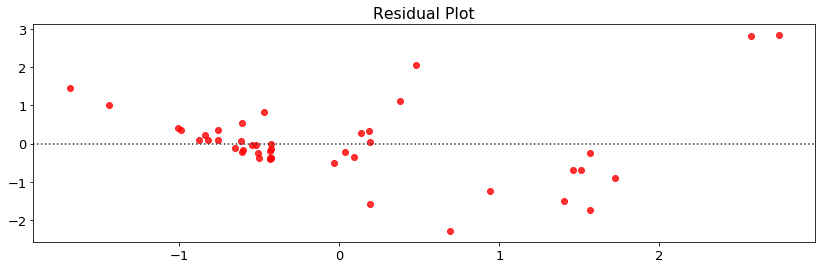

In [896]:
linear_reg = LinearRegression().fit(X_train_sc, y_train)
preds = linear_reg.predict(X_test_sc)
linear_reg_eval = evaluate(preds, y_test, res_plot=True);

**Let's try adding Ploynomial Features as they will be very useful per our analysis**

In [833]:
pol_f = PolynomialFeatures().fit(X_train_sc)
X_train_sc_poly = pol_f.transform(X_train_sc)
X_test_sc_poly = pol_f.transform(X_test_sc)

MSE: 2.1353
MAE: 1.0228


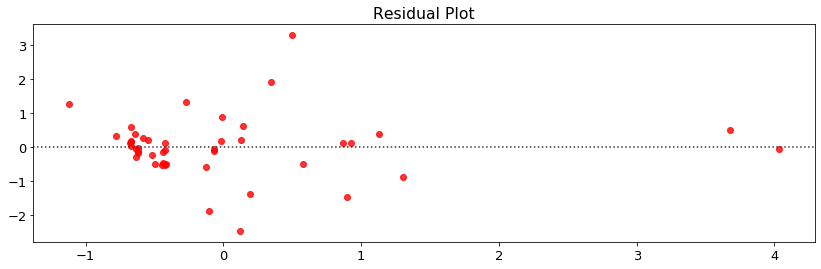

In [897]:
linear_reg = LinearRegression().fit(X_train_sc_poly, y_train)
preds = linear_reg.predict(X_test_sc_poly)
linear_poly_reg_eval = evaluate(preds, y_test, res_plot=True);

**Let's use Ridge to regularize the weights**

MSE: 2.1461
MAE: 1.0437


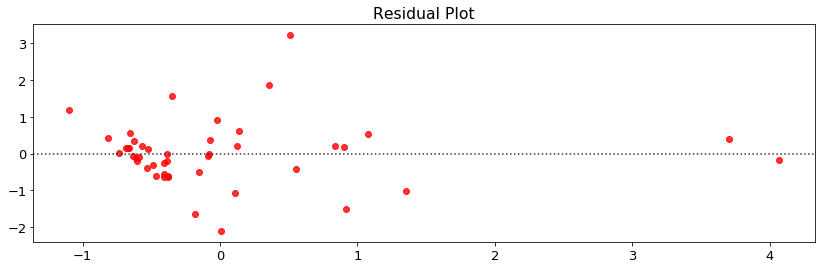

In [907]:
linear_reg_ridge = Ridge().fit(X_train_sc_poly, y_train)
preds = linear_reg_ridge.predict(X_test_sc_poly)
linear_poly_reg_ridge_eval = evaluate(preds, y_test, X_test_sc.shape[1]);

### Random Forest Regressor (Bagging)

MSE: 1.8743
MAE: 0.8535


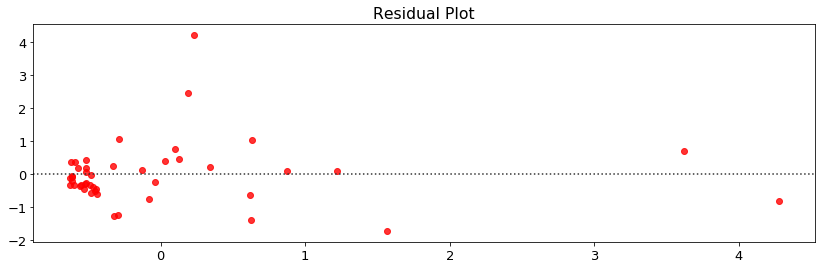

In [942]:
rf_reg = RandomForestRegressor(n_jobs=-1).fit(X_train_sc, y_train)
preds = rf_reg.predict(X_test_sc)
rf_reg_eval = evaluate(preds, y_test, res_plot=True);

**Let's try it with polynomials**

MSE: 1.8587
MAE: 0.8816


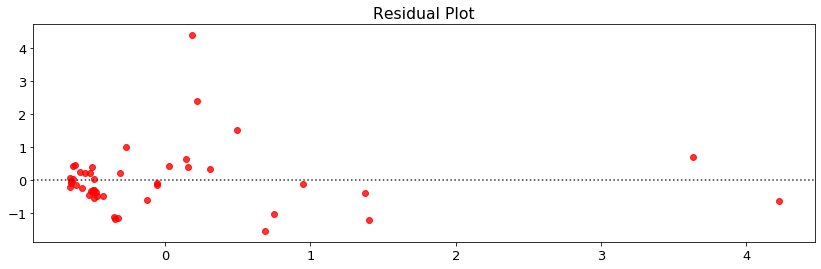

In [945]:
rf_reg = RandomForestRegressor(n_jobs=-1).fit(X_train_sc_poly, y_train)
preds = rf_reg.predict(X_test_sc_poly)
rf_reg_poly_eval = evaluate(preds, y_test, res_plot=True);

**Let's add car names One-Hot-Encodes**

Bagging Trees are good when having many features. It will sample features randomly as well as sampling examples. Then aggregation is done. It's an in-built feature selection technique

In [914]:
X_train_cars = X_train_sc.merge(car_name, left_index=True, right_index=True)
X_test_cars = X_test_sc.merge(car_name, left_index=True, right_index=True)

scaler = StandardScaler().fit(X_train_cars)
X_train_sc_cars = scaler.transform(X_train_cars)
X_test_sc_cars = scaler.transform(X_test_cars)

X_train_sc_cars = pd.DataFrame(X_train_sc_cars, index=X_train_cars.index, columns=X_train_cars.columns)
X_test_sc_cars = pd.DataFrame(X_test_sc_cars, index=X_test_cars.index, columns=X_test_cars.columns)

MSE: 0.2709
MAE: 0.3915


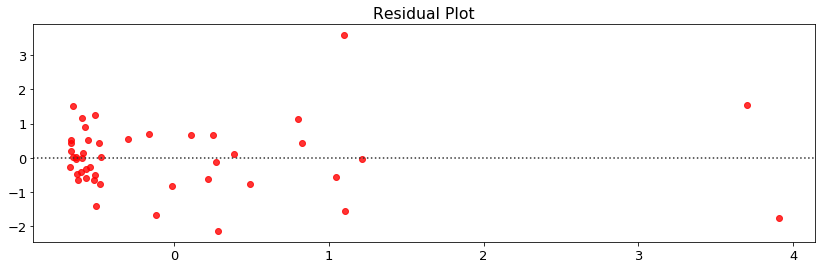

In [939]:
rf_reg = RandomForestRegressor(n_jobs=-1, max_features=20).fit(X_train_sc_cars, y_train)
preds = rf_reg.predict(X_test_sc_cars)
rf_reg_cars_eval = evaluate(preds, y_test, X_test_sc_cars.shape[1]);

**We can also add Voting Regressor with our 2 best models and weight the better higher**

**But I'll stop here**

# Eval Summary

In [946]:
MODELS_EVAL = [linear_reg_eval, 
               linear_poly_reg_eval,
               linear_poly_reg_ridge_eval, 
               rf_reg_eval, 
               rf_reg_poly_eval, 
               rf_reg_cars_eval]

regressors = ['Linear', 
              'Linear | Ploynomial', 
              'Linear Ridge | Polynomial', 
              'Random Forest', 
              'Random Forest | Polynomial', 
              'Random Forest | Car Feature']
df_eval = pd.DataFrame(MODELS_EVAL, index=regressors, columns=['MSE', 'MAE'])

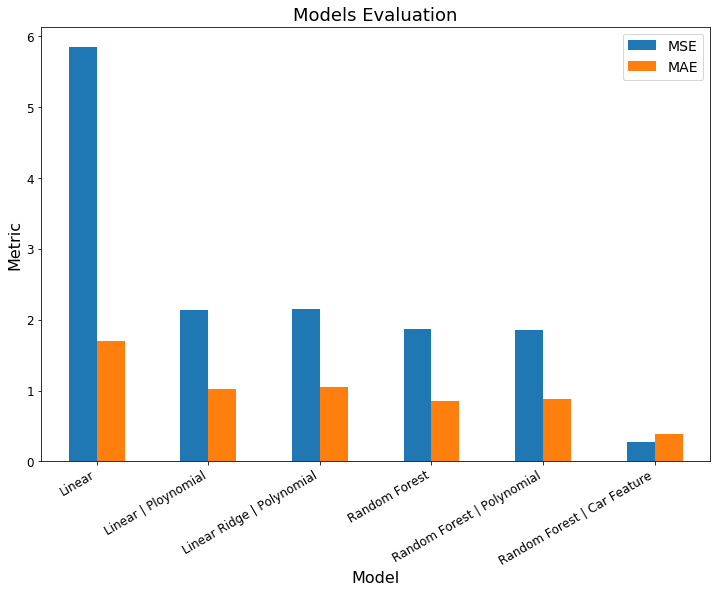

In [968]:
ax = df_eval.plot(kind='bar');
ax.set_xlabel("Model", fontsize=16)
ax.set_ylabel("Metric", fontsize=16)
ax.set_title('Models Evaluation', fontsize=18);
ax.tick_params(labelsize=12)
plt.xticks(rotation=30, ha='right');    
ax.legend(loc='upper right');

# Conclusion

- The best model was Random Forest Regressor using many features and selecting within
- Adding Polynomial Features (Which makes it Interaction Linear Regression) have optimize the linear regressor dramatically, as we have scene, there were many combinations of variables that can be possible predictors of our target value
- Note that giving car features to any other linear model will ruin the prediction. The MSE or MAE will goes up for sure if there's no selection
- We could have used Kernel-Based models (SVM or just applying the kernel trick on any model) for the features exculding cars. The possibility of having a better quality is high. As applying polynomial features has increased the quality due to the ability of regression on a higher diminsions.
- We have not selected the features that we have chosen in our analysis which was a proof of concept due to not only time, but also the usage of RFC Regressor
- One of the notes I have written above were talking about multiple techniques we could have done to better optimize the models quality, one of them is using SMOTE or GANs to synthesize more samples
- Box plot should also be used to strictly detect possible outliers, IQR with a factor of 3 is also a good measure to detect extreme values, one way that might also be useful is to throw out the outliers but this decision is business-dependant. 
- I have not reviewed any misspellings so excuse me if there were

***Thank you***